# GPU


In [ ]:
!nvidia-smi

Sat Sep 26 00:07:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports and Data Formatting 

In [ ]:
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.python.keras.initializers import RandomUniform

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
tf.keras.__version__

'2.4.0'

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
data = pd.read_csv("/content/drive/My Drive/MarketModel2/21p_2010_2020.csv")
new_test = pd.read_csv("/content/drive/My Drive/MarketModel2/21p_latest_test.csv")

In [ ]:
data = data.drop('DATE1', axis=1)
data = data.drop('DATE2', axis=1)
#data = data.drop('DATE3', axis=1)

In [ ]:
new_test = new_test.drop('DATE1', axis=1)
new_test = new_test.drop('DATE2', axis=1)

In [ ]:
target_label = 'SP500_PCH'#'WILL5000PRFC_PCH'#
target_names = ['SP500_PCH']#['WILL5000PRFC_PCH']#

In [ ]:
shift_steps = 1 #Number of weeks ahead of prediction

In [ ]:
data_targets = data[target_label].shift(-shift_steps)


In [ ]:
#new_test_targets = new_test[target_label].shift(-shift_steps)

In [ ]:
data.shape

(519, 21)

In [ ]:
x_data = data.iloc[:,1:].copy().values[0:-shift_steps]

print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (518, 20)


In [ ]:
x_new_test = new_test.iloc[:,1:].copy().values[0:-shift_steps]

print(type(x_new_test))
print("Shape:", x_new_test.shape)

<class 'numpy.ndarray'>
Shape: (9, 20)


In [ ]:
y_data = data_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (518,)


In [ ]:
#y_new_test = new_test_targets.values[:-shift_steps]

#print(type(y_new_test))
#print("Shape:", y_new_test.shape)

In [ ]:
#Reshape y data into 2D arrays
y_data= y_data.reshape(-1,1)
y_data= y_data.reshape(-1,1)

In [ ]:
#Reshape y test into 2D arrays
#y_new_test= y_new_test.reshape(-1,1)
#y_new_test= y_new_test.reshape(-1,1)

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

20

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [ ]:
n_data = len(x_data)
n_data

518

In [ ]:
train_split = 0.8

In [ ]:
n_train = int(n_data*train_split)
n_train

414

In [ ]:
n_test = n_data - n_train
n_test

104

In [ ]:
x_train = x_data[0:n_train]
x_test = x_data[n_train:]
len(x_train) + len(x_test)


518

In [ ]:
y_train = y_data[0:n_train]
y_test = y_data[n_train:]
len(y_train) + len(y_test)

518

In [ ]:
#Min and max of the data set
print("Min:", np.min(y_train))
print("Max:", np.max(y_train))

Min: -9.10314
Max: 4.57817


In [ ]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [ ]:
#x_new_test_scaled = x_scaler.transform(x_new_test)

In [ ]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
#y_new_test_scaled = y_scaler.transform(y_new_test)

In [ ]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(414, 20)
(414, 1)


In [ ]:
x_train_scaled = np.expand_dims(x_train_scaled, axis=0)
y_train_scaled = np.expand_dims(y_train_scaled, axis=0)

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Creating the Model



In [ ]:
model = Sequential()

model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals)))




In [ ]:
init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals,
                activation='linear',
                kernel_initializer=init))

"""model.add(Dense(num_y_signals, activation='sigmoid'))"""



"model.add(Dense(num_y_signals, activation='sigmoid'))"

In [ ]:
warmup_steps = 10

In [ ]:
def loss_mse(y_target, y_pred):

    y_target_slice = y_target[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    mse = mean(square(y_target_slice - y_pred_slice))
    
    return mse

In [ ]:
optimizer = RMSprop(lr=1e-3)

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_23 (GRU)                 (None, None, 512)         820224    
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           513       
Total params: 820,737
Trainable params: 820,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# To save checkpoints during training
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# Stops training when performance worsens
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [ ]:
# For writing the TensorBoard
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
# Adusts learning rate as needed
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]\

# Training

In [ ]:
%%time
history = model.fit(x_train_scaled,
          y_train_scaled,
          epochs=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4648 - mse: 0.4648 - val_loss: 0.1413 - val_mse: 0.1413

Epoch 00001: val_loss improved from inf to 0.14127, saving model to checkpoint.keras
Epoch 2/100
1/1 [==============================] - 1s 655ms/step - loss: 0.1314 - mse: 0.1314 - val_loss: 0.0420 - val_mse: 0.0420

Epoch 00002: val_loss improved from 0.14127 to 0.04198, saving model to checkpoint.keras
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.1754 - val_mse: 0.1754

Epoch 00003: val_loss did not improve from 0.04198

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 0.1136 - mse: 0.1136 - val_loss: 0.1706 - val_mse: 0.1706

Epoch 00004: val_loss did not improve from 0.04198

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 5/100
1/1 [==============================] - 0s

In [ ]:

result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 16ms/step - loss: 0.1194 - mse: 0.1194


# Predictions

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

{'loss': [0.4648419916629791, 0.1314409375190735, 0.013983001932501793, 0.11360176652669907, 0.10935747623443604, 0.0970018208026886, 0.08197436481714249], 'mse': [0.4648419916629791, 0.1314409375190735, 0.013983001932501793, 0.11360176652669907, 0.10935747623443604, 0.0970018208026886, 0.08197436481714249], 'val_loss': [0.14126980304718018, 0.04197541996836662, 0.1753506362438202, 0.17061764001846313, 0.15599700808525085, 0.1378583312034607, 0.11941376328468323], 'val_mse': [0.14126980304718018, 0.04197541996836662, 0.1753506362438202, 0.17061764001846313, 0.15599700808525085, 0.1378583312034607, 0.11941376328468323], 'lr': [0.001, 0.001, 0.001, 0.000100000005, 1e-04, 1e-04, 1e-04]}
dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


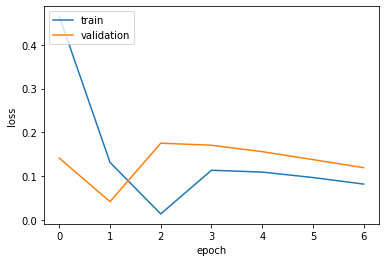

In [ ]:
print(history.history)
print(history.history.keys())
# "Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

{'loss': [0.4648419916629791, 0.1314409375190735, 0.013983001932501793, 0.11360176652669907, 0.10935747623443604, 0.0970018208026886, 0.08197436481714249], 'mse': [0.4648419916629791, 0.1314409375190735, 0.013983001932501793, 0.11360176652669907, 0.10935747623443604, 0.0970018208026886, 0.08197436481714249], 'val_loss': [0.14126980304718018, 0.04197541996836662, 0.1753506362438202, 0.17061764001846313, 0.15599700808525085, 0.1378583312034607, 0.11941376328468323], 'val_mse': [0.14126980304718018, 0.04197541996836662, 0.1753506362438202, 0.17061764001846313, 0.15599700808525085, 0.1378583312034607, 0.11941376328468323], 'lr': [0.001, 0.001, 0.001, 0.000100000005, 1e-04, 1e-04, 1e-04]}
dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


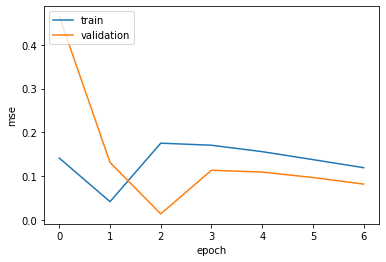

In [ ]:
print(history.history)
print(history.history.keys())
# "Loss


plt.plot(history.history['val_mse'])
plt.plot(history.history['mse'])
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def plot_comparison(start_idx, length=100, train=True, latest=False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled[0]
        y_true = y_train
   # if latest and not train:
        # Use new-test-data.
        #x = np.expand_dims(x_new_test_scaled, axis=0)[0]
        #y_true = y_new_test
    if not train and not latest:
        # Use test-data.
        x = np.expand_dims(x_test_scaled, axis=0)[0]
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

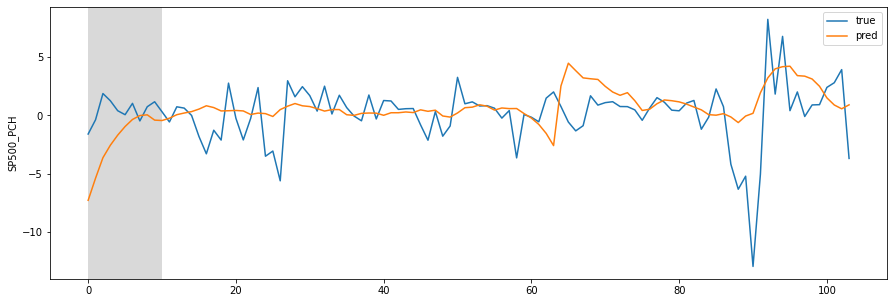

In [ ]:
plot_comparison(start_idx=0, length=52*2, train=False, latest=False)